# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,80444000.0,26.048,-66.325,21.12,528,801.0,798.0,1591.9,0,119,0.00000,0.0
1,80444010.0,26.054,-66.332,21.12,528,803.0,798.0,1594.6,0,119,0.00816,10.0
2,80444020.0,26.061,-66.338,21.12,528,789.0,785.0,1593.3,0,119,0.01633,20.0
3,80444030.0,26.063,-66.342,21.12,528,785.0,790.0,1580.7,0,119,0.02449,30.0
4,80444040.0,26.066,-66.345,21.12,528,785.0,790.0,1580.7,0,119,0.03265,40.0


Generate a temperature matrix

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [4]:
digits_round = 1
x_range = (26.264, 38.053)
y_range = (-66.506, -54.848)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_11514/437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_11514/437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [5]:
list_25l.shape

(25, 117, 118)

Objective of the approach: identify and analyze regions with anomalous temperature behavior in each layer.

Idea: performing layer-wise clustering of image data using PCA and K-means, and then extracting pixel information for the smallest and biggest clusters in each layer. Smallest and biggest clusters depend on the how a pixel was considered extreme in the principal component space.
A pixel was considered extreme if its value was far from the average or typical values in the dataset. After applying PCA, a pixel was considered extreme if it had a high Hotelling’s T² statistic, meaning it lied far from the center of the principal component space. These extreme points represented regions with anomalous temperature behavior compared to the rest of the pixels and were collected in a cluster called "Smallest Cluster". On the other hand, the pixels outside those regions were stored in "Biggest Cluster".

In order to come up with a dataframe that helps in differentiating between smallest and biggest clusters, the following process was followed:
- Standardization before PCA: compulsory since the variables had different scales.
PCA is sensitive to the scale of the variables. If the input data are not standardized, variables with larger scales will dominate the principal components, leading to biased results.
- Application of PCA to reduce dimensionality
- Computation of the Hotelling’s T² statistic for each pixel, measuring how extreme each pixel was in the principal component space.
- Application of K-means clustering (with 2 clusters) to the T² values, segmenting the pixels into a group with points with less extremes values on the principal component space and another group with more extreme values.
K-means clustering is also sensitive to scale. If $T^2$ values have a wide range or are skewed, clusters may be biased toward higher-magnitude values. For this reason, standardization of $T^2$ was required for ensuring that clustering was based on relative differences, not absolute magnitudes, making the clustering more robust and meaningful.

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)

num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []
biggest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest and biggest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)
    biggest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates and values for the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]
    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

    # Extract the pixel coordinates and values for the biggest cluster
    biggest_cluster_indices = np.where(clusters_map == biggest_cluster_label)
    biggest_cluster_coords = list(zip(biggest_cluster_indices[0], biggest_cluster_indices[1]))
    biggest_cluster_values = current_layer_scaled[biggest_cluster_indices]
    biggest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": biggest_cluster_label,
        "pixel_coordinates": biggest_cluster_coords,
        "pixel_values": biggest_cluster_values
    })

# Print the extracted pixels for each layer
for layer_data in smallest_cluster_pixels:
    print(f"Layer: {layer_data['layer']}")
    print(f"  Smallest Cluster Label: {layer_data['cluster_label']}")
    print(f"  Number of Pixels in Smallest Cluster: {len(layer_data['pixel_coordinates'])}")
    print(f"  Pixel Coordinates (row, col): {layer_data['pixel_coordinates'][:5]} ...")
    print(f"  Pixel Values (Standardized): {layer_data['pixel_values'][:5]} ...\n")

Layer: 1
  Smallest Cluster Label: 1
  Number of Pixels in Smallest Cluster: 1365
  Pixel Coordinates (row, col): [(0, 0), (0, 2), (0, 4), (0, 6), (0, 7)] ...
  Pixel Values (Standardized): [2.73293495 2.48662875 2.30164712 3.15602331 1.89156843] ...

Layer: 2
  Smallest Cluster Label: 1
  Number of Pixels in Smallest Cluster: 2226
  Pixel Coordinates (row, col): [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)] ...
  Pixel Values (Standardized): [-3.28036093 -1.99047286 -1.88562663 -1.84769362 -2.74644864] ...

Layer: 3
  Smallest Cluster Label: 1
  Number of Pixels in Smallest Cluster: 2561
  Pixel Coordinates (row, col): [(0, 1), (0, 3), (0, 4), (0, 6), (0, 8)] ...
  Pixel Values (Standardized): [1.69797352 1.43052189 1.48492405 1.41696205 1.4280867 ] ...

Layer: 4
  Smallest Cluster Label: 1
  Number of Pixels in Smallest Cluster: 2215
  Pixel Coordinates (row, col): [(0, 0), (0, 1), (0, 3), (0, 9), (0, 14)] ...
  Pixel Values (Standardized): [ 2.88893029  3.74311288  2.66728357 -2.21978574

>Comment the result: IDK

The "Smallest Cluster" was then matched with the original data list to give to each pixel the (x,y) coordinates and to specify the layer_id.

In [7]:
# Create a list to store the data
data = []

# Iterate through each layer's smallest cluster data
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

,x,y,temp_std,layer_id
0,0,0,2.732935,1
1,2,0,2.486629,1
2,4,0,2.301647,1
3,6,0,3.156023,1
4,7,0,1.891568,1


A chart was drawn to see how the extreme pixels with anomalous temperature behavior were distributed.

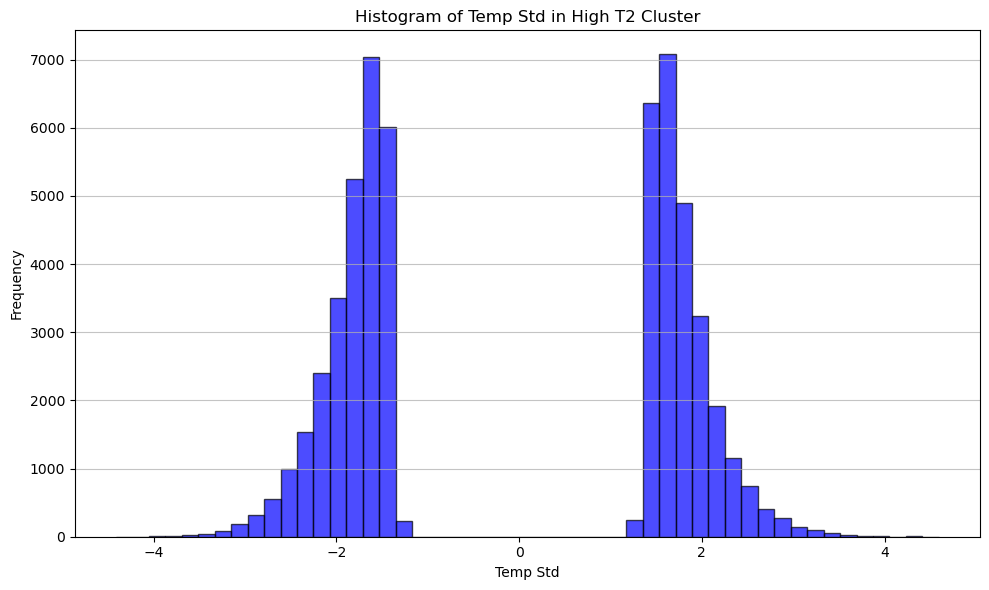

In [8]:
import matplotlib.pyplot as plt

# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

>The plot clearly stated that the standardized temperatures in the High T^2 cluster was bimodal, signaling the presence of cold and hot spots. A clear point of separation was at a zero value of the standardized temperature, giving a clear suggestion on how setting a threshold to split the data.

In [12]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)

# Display the first few rows of each DataFrame
cold_spots.head(), hot_spots.head()

(    x  y  temp_std  layer_id
 0  56  1 -1.737914         1
 1  62  1 -1.816186         1
 2  68  2 -2.182259         1
 3  48  3 -2.951796         1
 4  53  4 -1.808503         1,
    x  y  temp_std  layer_id
 0  0  0  2.732935         1
 1  2  0  2.486629         1
 2  4  0  2.301647         1
 3  6  0  3.156023         1
 4  7  0  1.891568         1)

### Cold spots analysis

To analyze how Cold Spots behave, a first plot on the pattern of the data was required. Moreover, to start designing control charts, the assumptions of normality and independence were checked.

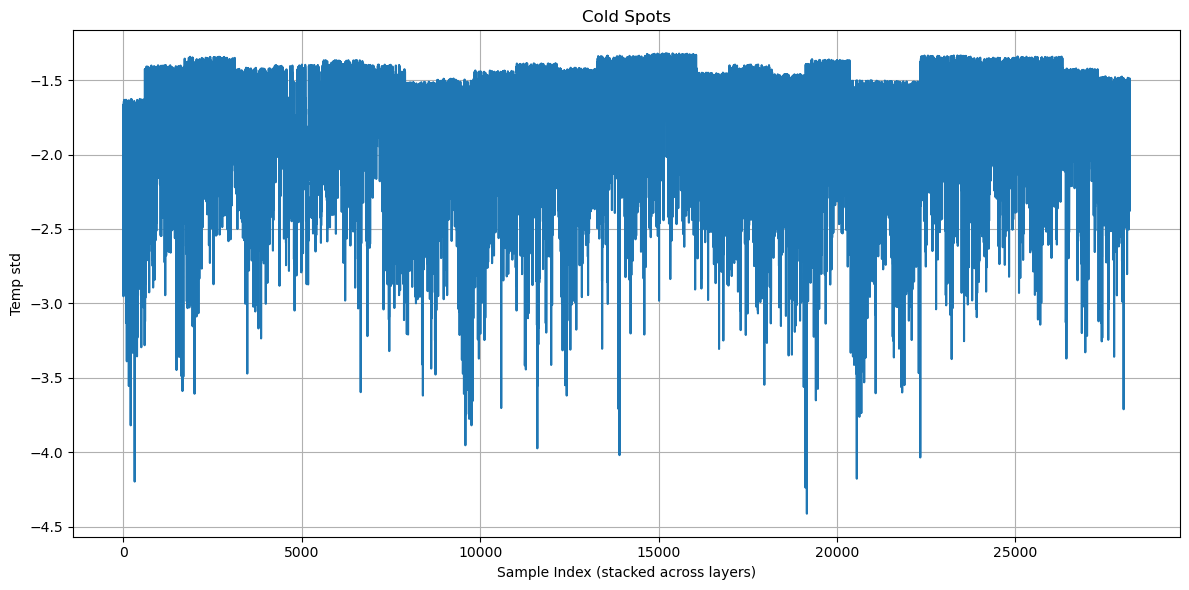

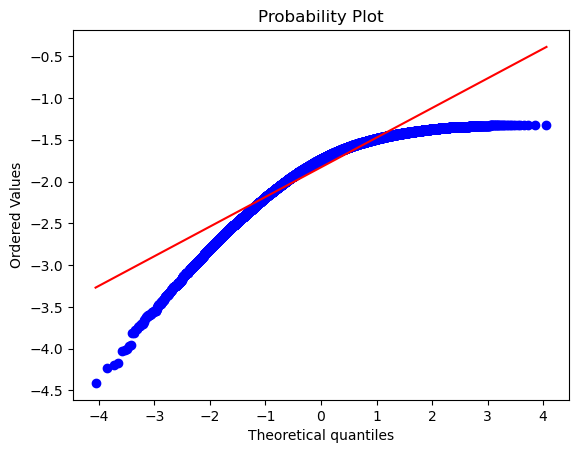

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.897
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.415
Runs test p-value = 0.000



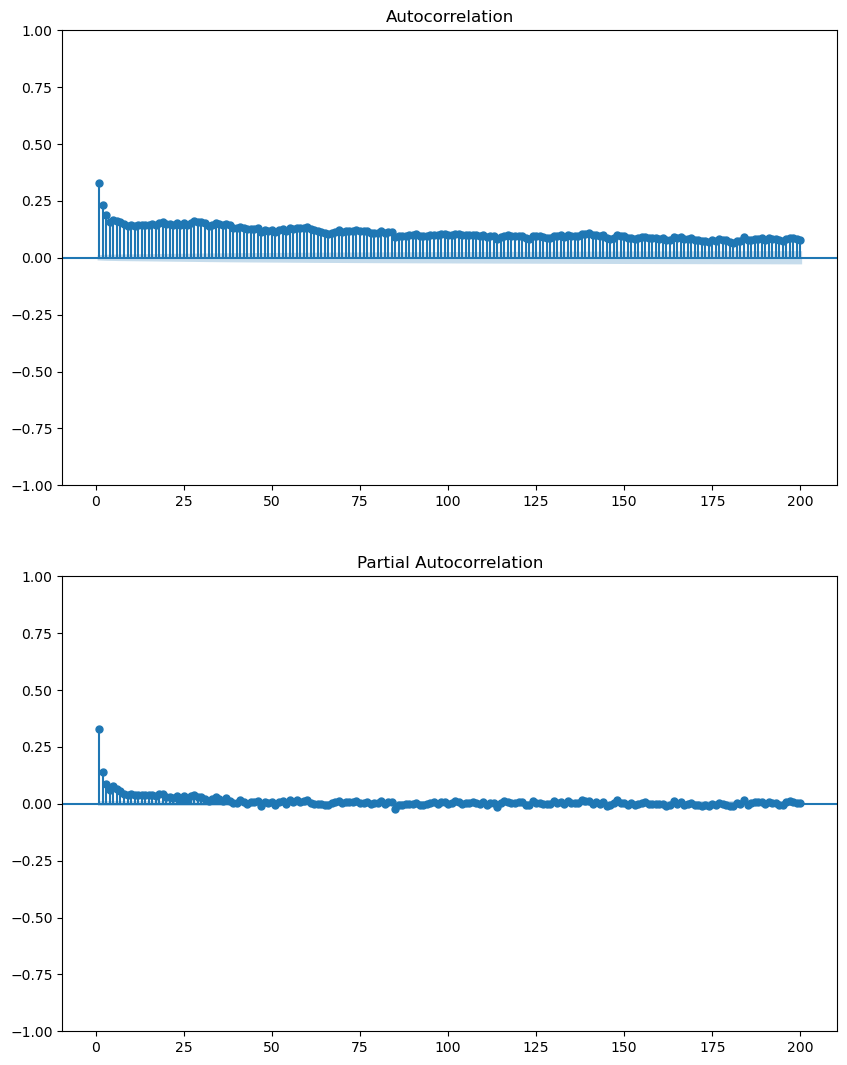

In [10]:
import matplotlib.pyplot as plt

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

import qdatoolkit as qda

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Controllo di indipendenza

>Both assumptions were clearly unmet, suggesting that a further data modeling was required.

A further step to meet the normality assumption was done exploiting a non linear regression model, specifically the Random Forest methodology.
This algorithm helps in finding a meandering pattern on the dataset.
The con of this approach stands on the construction of the model given its low interpretability.

In [13]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare features and target
X = cold_spots[['layer_id', 'x', 'y']].values
y = cold_spots['temp_boxcox'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


KeyError: 'temp_boxcox'

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train predictions and metrics
y_train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Test predictions and metrics
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

print(f"Train MAE: {mae_train:.4f}, MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, R^2: {r2_train:.4f}")
print(f"Test  MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R^2: {r2_test:.4f}")

NameError: name 'model' is not defined

Residuals were extracted and analyzed:

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


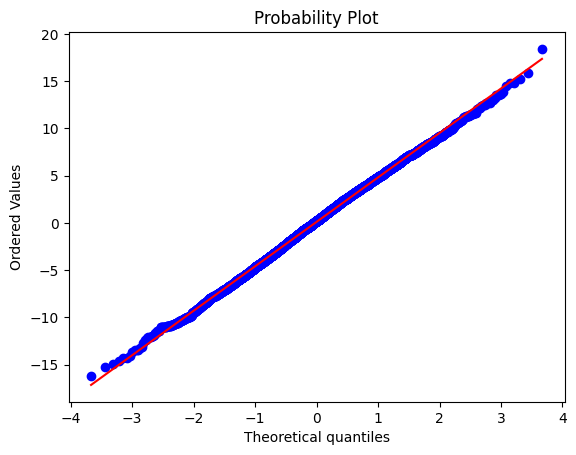

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.999
Shapiro-wilk test p-value = 0.001
Runs test statistic = 0.564
Runs test p-value = 0.573



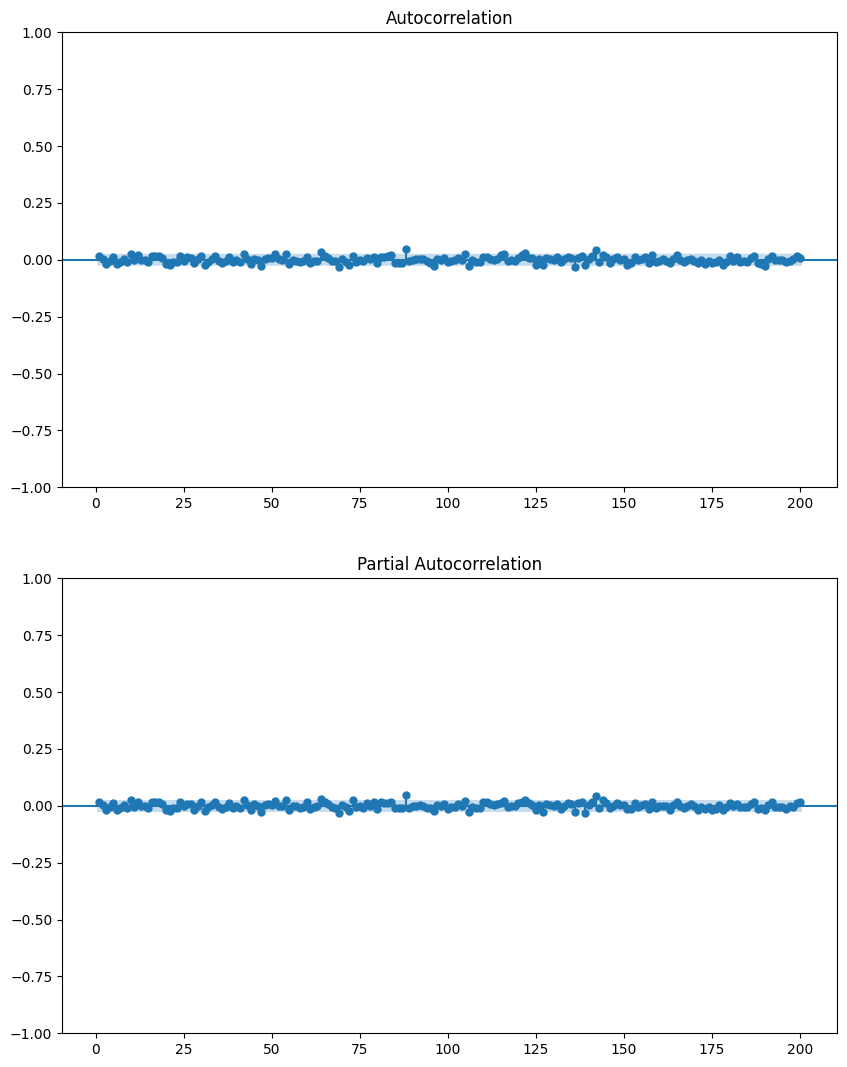

In [103]:
residuals = y_test - y_pred
_=qda.Assumptions(residuals).normality()  # Controllo di normalità
_=qda.Assumptions(residuals).independence()  # Controllo di

Both indipendence and normality were met.

In [104]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result = anderson(residuals, dist='norm')

print("Anderson-Darling Test Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

# Interpret the result
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 1.8399065979847364
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


In [105]:
from statsmodels.stats.stattools import durbin_watson

# Perform the Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.966325137630012


On the extracted residuals of the model was possible designinga an I-MR control chart for checking cold spots.

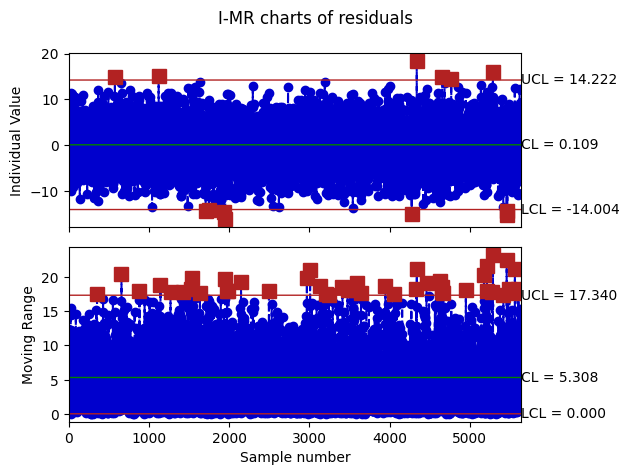

In [107]:
# Create a DataFrame for the residuals
df_SCC = pd.DataFrame(residuals, columns=['residuals'])

# Plot the I-MR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'residuals')

In [108]:
# Conta i punti fuori controllo nella carta I (Individual)
out_of_control_I = ((df_SCC_IMR['residuals'] > df_SCC_IMR['I_UCL']) | (df_SCC_IMR['residuals'] < df_SCC_IMR['I_LCL'])).sum()

# Conta i punti fuori controllo nella carta MR (Moving Range)
out_of_control_MR = ((df_SCC_IMR['MR'] > df_SCC_IMR['MR_UCL']) | (df_SCC_IMR['MR'] < df_SCC_IMR['MR_LCL'])).sum()

print(f"Punti fuori controllo nella carta I: {out_of_control_I}")
print(f"Punti fuori controllo nella carta MR: {out_of_control_MR}")

Punti fuori controllo nella carta I: 13
Punti fuori controllo nella carta MR: 45


>The points out of the limits in the I chart represented the ...%
>The points out of the limits in the MR chart represented the ...%

>Assuming an in control process, those results shown us how the high validity of the control chart due to the low level of out of controls.

### Hot spots

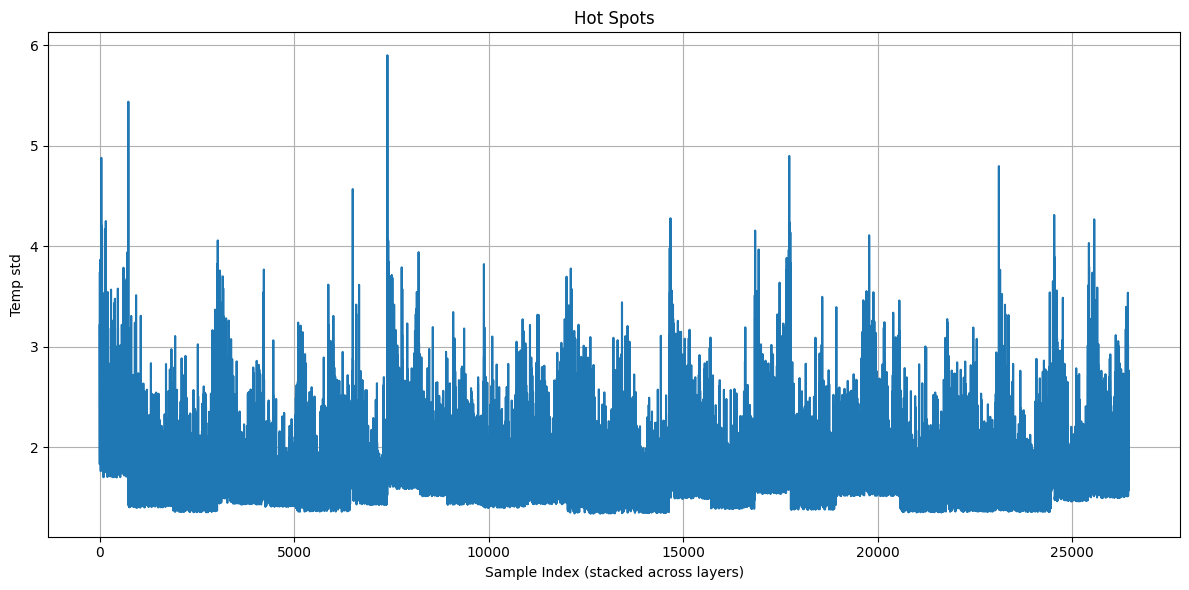

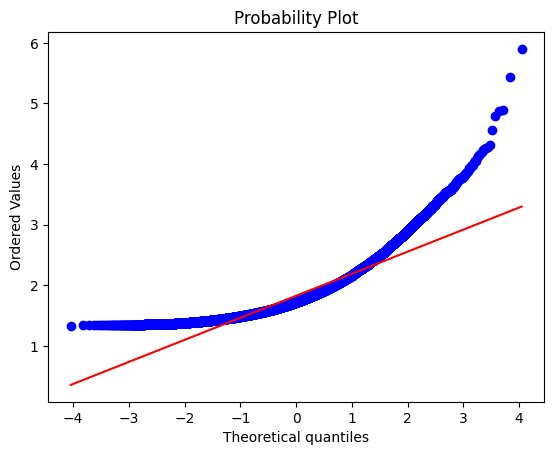

Shapiro-wilk test statistic = 0.862
Shapiro-wilk test p-value = 0.000
Runs test statistic = -35.809
Runs test p-value = 0.000



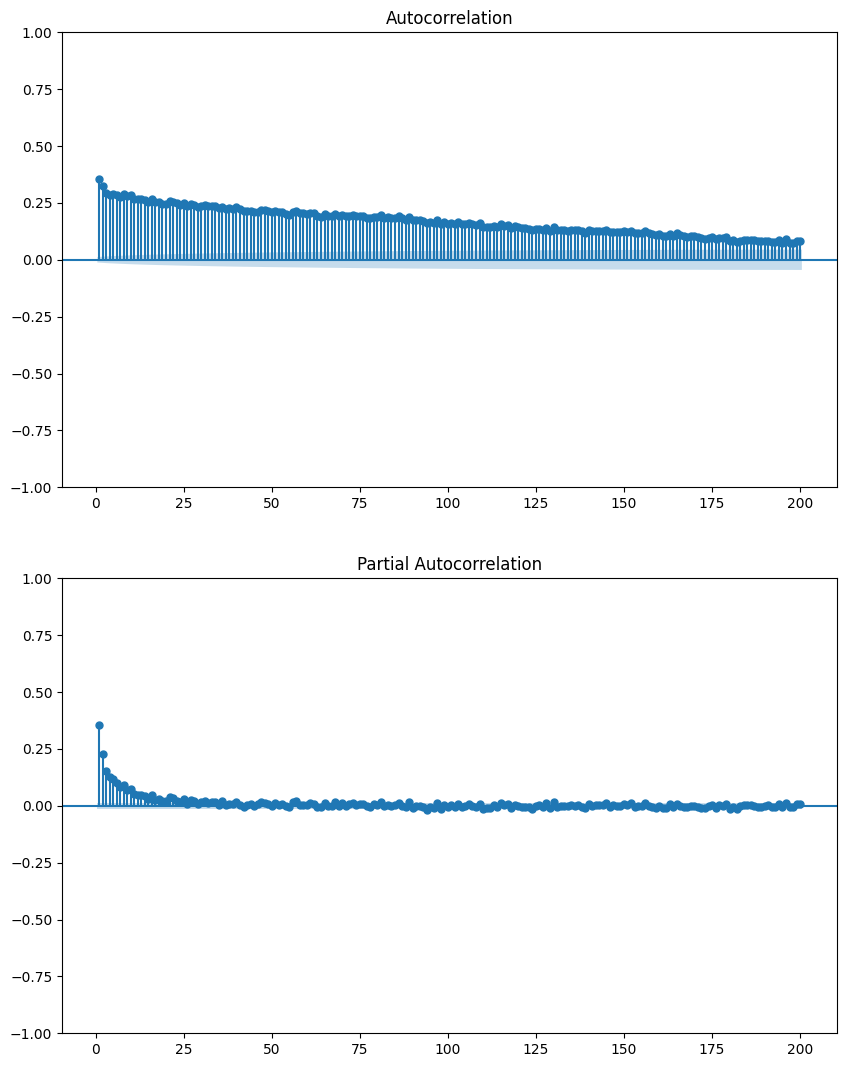

In [11]:
import matplotlib.pyplot as plt

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(hot_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Hot Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

import qdatoolkit as qda

_ = qda.Assumptions(hot_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(hot_spots['temp_std']).independence()  # Controllo di indipendenza

Box-Cox lambda: -2.1549
Normality test p-value after Box-Cox: 0


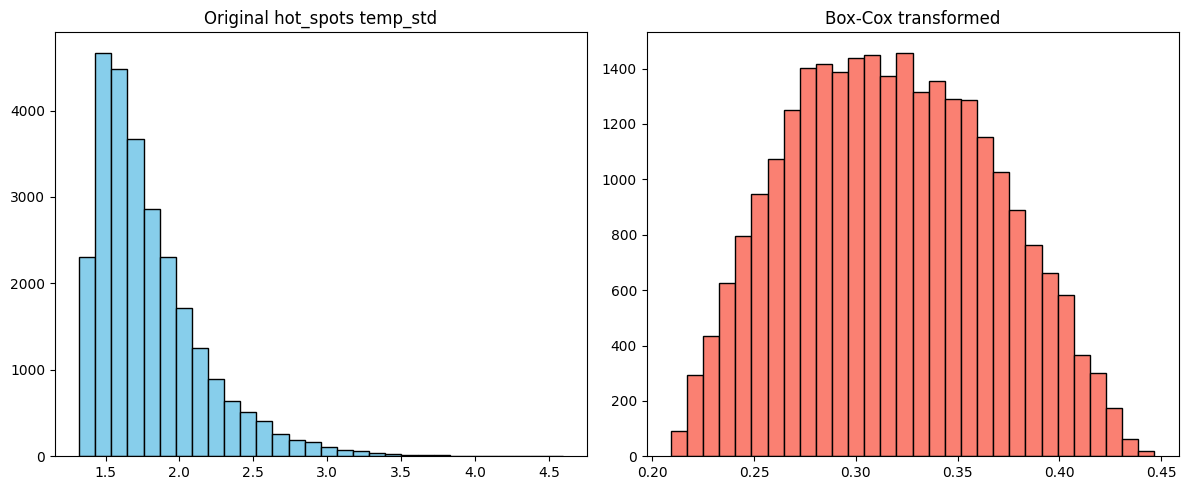

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


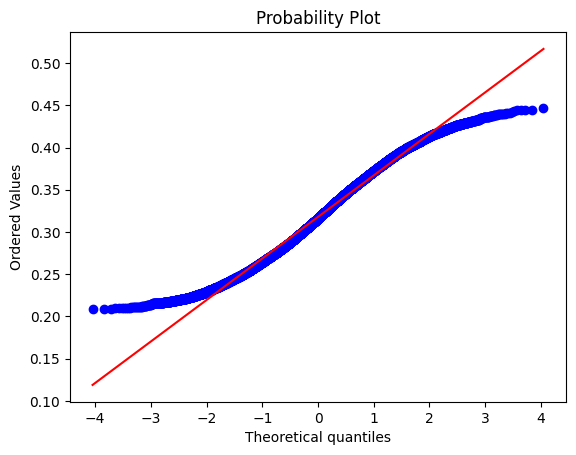

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.986
Shapiro-wilk test p-value = 0.000
Runs test statistic = -26.563
Runs test p-value = 0.000



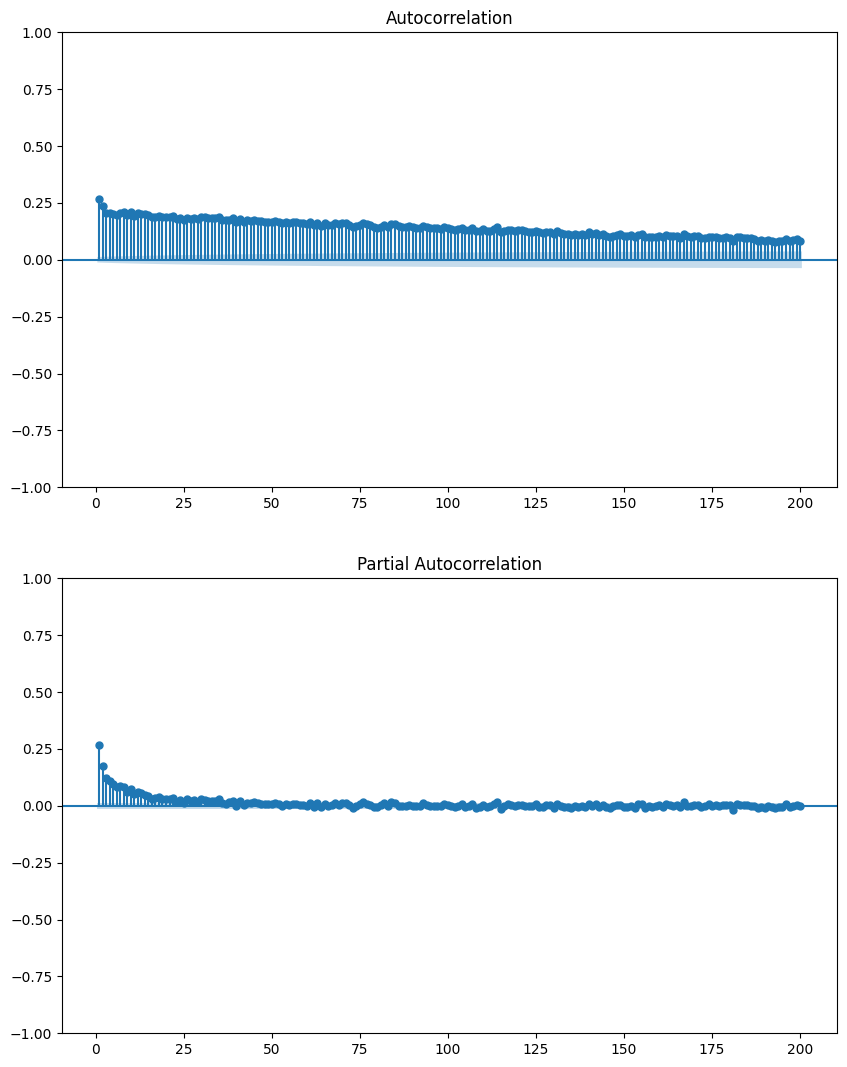

In [109]:
from scipy.stats import boxcox, normaltest
import matplotlib.pyplot as plt

# Box-Cox richiede valori > 0, quindi trasliamo i dati se necessario
min_val_hs = hot_spots['temp_std'].min()
if min_val_hs <= 0:
    shift = abs(min_val_hs) + 1e-6
else:
    shift = 0

temp_shifted_hs = hot_spots['temp_std'] + shift
temp_boxcox_hs, fitted_lambda_hs = boxcox(temp_shifted_hs)

# Aggiungi la colonna trasformata al DataFrame
hot_spots['temp_boxcox_hs'] = temp_boxcox_hs

# Test di normalità dopo la trasformazione
stat, p_hs = normaltest(temp_boxcox_hs)
print(f"Box-Cox lambda: {fitted_lambda_hs:.4f}")
print(f"Normality test p-value after Box-Cox: {p_hs:.4g}")

# Plot confronto prima e dopo
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(hot_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original hot_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_hs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_=qda.Assumptions(temp_boxcox_hs).normality()  # Controllo di normalità
_=qda.Assumptions(temp_boxcox_hs).independence()  # Controllo di indipendenza

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare features and target
X_hs = hot_spots[['layer_id', 'x', 'y']].values
y_hs = hot_spots['temp_boxcox_hs'].values

# Split the data
X_train_hs, X_test_hs, y_train_hs, y_test_hs = train_test_split(X_hs, y_hs, test_size=0.2, random_state=42)

# Train the model
model_hs = RandomForestRegressor(n_estimators=100, random_state=42)
model_hs.fit(X_train_hs, y_train_hs)

# Predict and evaluate
y_pred_hs = model_hs.predict(X_test_hs)
mse_hs = mean_squared_error(y_test_hs, y_pred_hs)
print(f"Mean Squared Error: {mse_hs}")

Mean Squared Error: 0.002072962628501697


/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


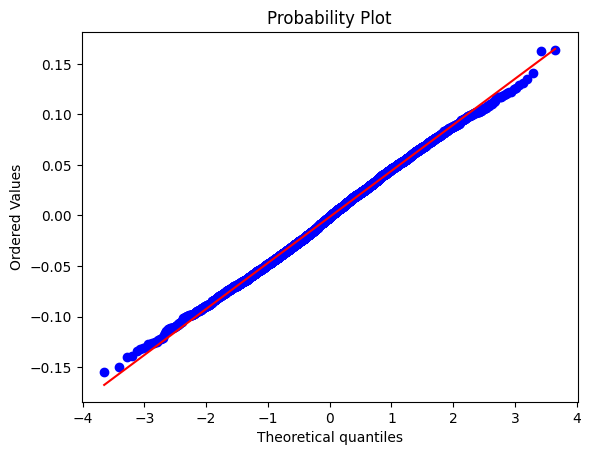

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.998
Shapiro-wilk test p-value = 0.000
Runs test statistic = 0.972
Runs test p-value = 0.331



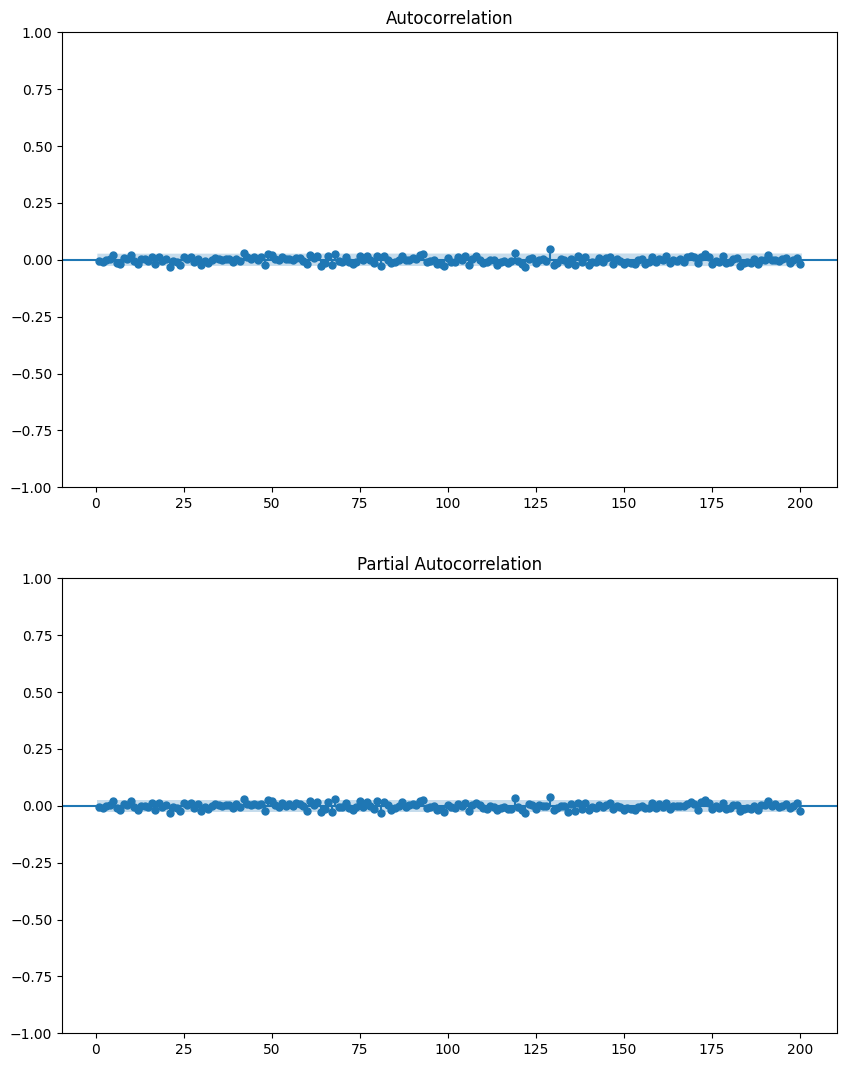

In [112]:
residuals_hs = y_test_hs - y_pred_hs
_=qda.Assumptions(residuals_hs).normality()  # Controllo di normalità
_=qda.Assumptions(residuals_hs).independence()  # Controllo di

In [113]:
from scipy.stats import anderson

# Perform Anderson-Darling test for normality
result_hs = anderson(residuals_hs, dist='norm')

print("Anderson-Darling Test Statistic:", result_hs.statistic)
print("Critical Values:", result_hs.critical_values)
print("Significance Levels:", result_hs.significance_level)

# Interpret the result
for i in range(len(result_hs.critical_values)):
    sl_hs, cv_hs = result_hs.significance_level[i], result_hs.critical_values[i]
    if result_hs.statistic < cv_hs:
        print(f"At {sl_hs}% significance level, the residuals appear to be normally distributed.")
    else:
        print(f"At {sl_hs}% significance level, the residuals do not appear to be normally distributed.")

Anderson-Darling Test Statistic: 2.6838909205343953
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level, the residuals do not appear to be normally distributed.
At 10.0% significance level, the residuals do not appear to be normally distributed.
At 5.0% significance level, the residuals do not appear to be normally distributed.
At 2.5% significance level, the residuals do not appear to be normally distributed.
At 1.0% significance level, the residuals do not appear to be normally distributed.


In [114]:
from statsmodels.stats.stattools import durbin_watson

# Perform the Durbin-Watson test
dw_stat_hs = durbin_watson(residuals_hs)
print(f"Durbin-Watson statistic: {dw_stat_hs}")

Durbin-Watson statistic: 2.007806262950487


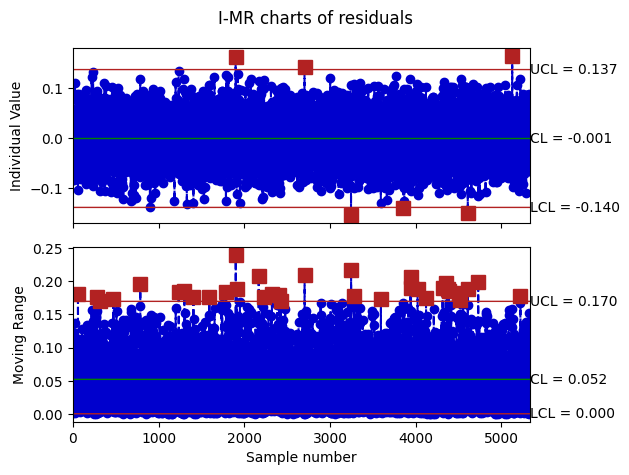

In [115]:
# Create a DataFrame for the residuals
df_SCC_hs = pd.DataFrame(residuals_hs, columns=['residuals'])

# Plot the I-MR control chart
df_SCC_IMR_hs = qda.ControlCharts.IMR(df_SCC_hs, 'residuals')

In [116]:
# Conta i punti fuori controllo nella carta I (Individual)
out_of_control_I_hs = ((df_SCC_IMR_hs['residuals'] > df_SCC_IMR_hs['I_UCL']) | (df_SCC_IMR_hs['residuals'] < df_SCC_IMR_hs['I_LCL'])).sum()

# Conta i punti fuori controllo nella carta MR (Moving Range)
out_of_control_MR_hs = ((df_SCC_IMR_hs['MR'] > df_SCC_IMR_hs['MR_UCL']) | (df_SCC_IMR_hs['MR'] < df_SCC_IMR_hs['MR_LCL'])).sum()

print(f"Punti fuori controllo nella carta I: {out_of_control_I_hs}")
print(f"Punti fuori controllo nella carta MR: {out_of_control_MR_hs}")

Punti fuori controllo nella carta I: 6
Punti fuori controllo nella carta MR: 34


# REGULAR POINTS

In [123]:
# Create a list to store the data for the biggest cluster
regular_data_list = []

# Iterate through each layer's biggest cluster data
for layer_data in biggest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        regular_data_list.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
regular_data = pd.DataFrame(regular_data_list)
regular_data.head()

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,3,0,0.606690,1
2,5,0,0.475641,1
3,9,0,1.329965,1
4,11,0,0.945900,1


In [131]:
# Batch the regular_data DataFrame by keeping 1 row every 5
regular_data_batched = regular_data.iloc[::5].reset_index(drop=True)
regular_data_batched.head()

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,13,0,0.973318,1
2,25,0,-0.714688,1
3,34,0,1.174879,1
4,41,0,0.929085,1


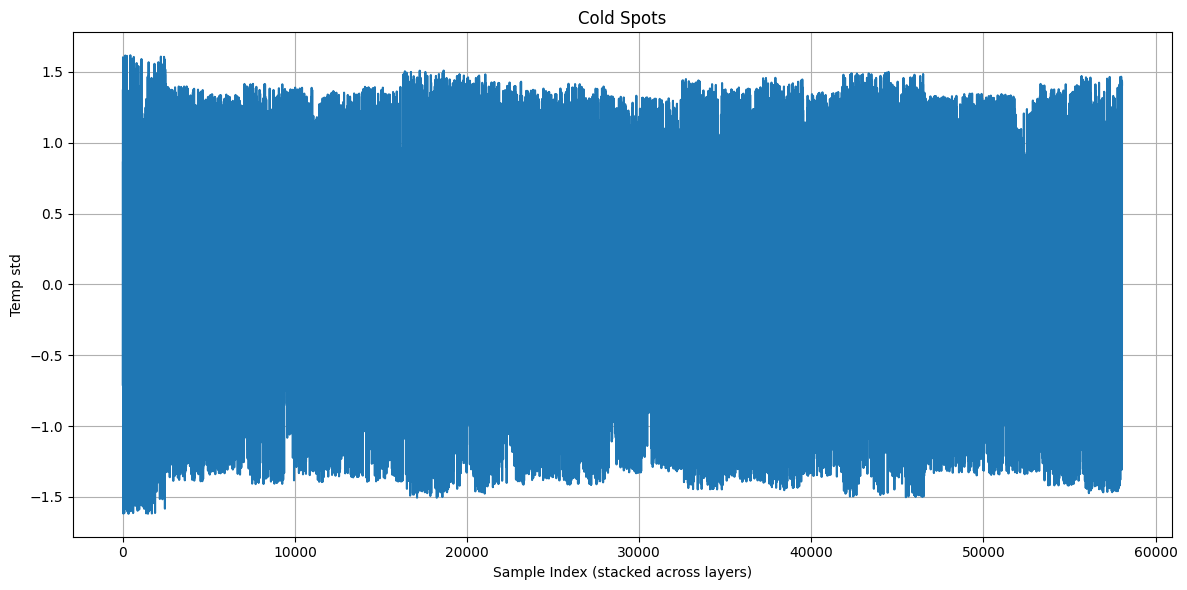

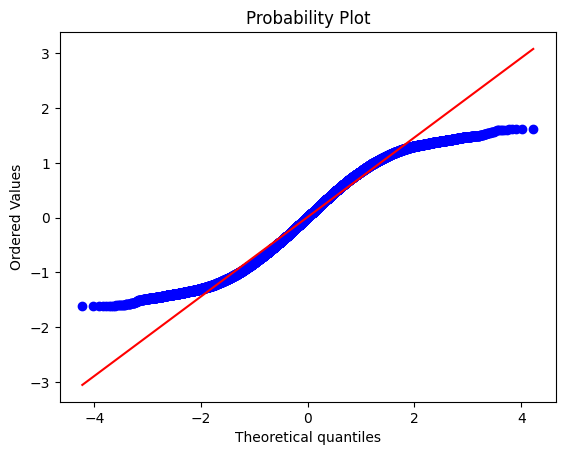

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.976
Shapiro-wilk test p-value = 0.000
Runs test statistic = -37.681
Runs test p-value = 0.000



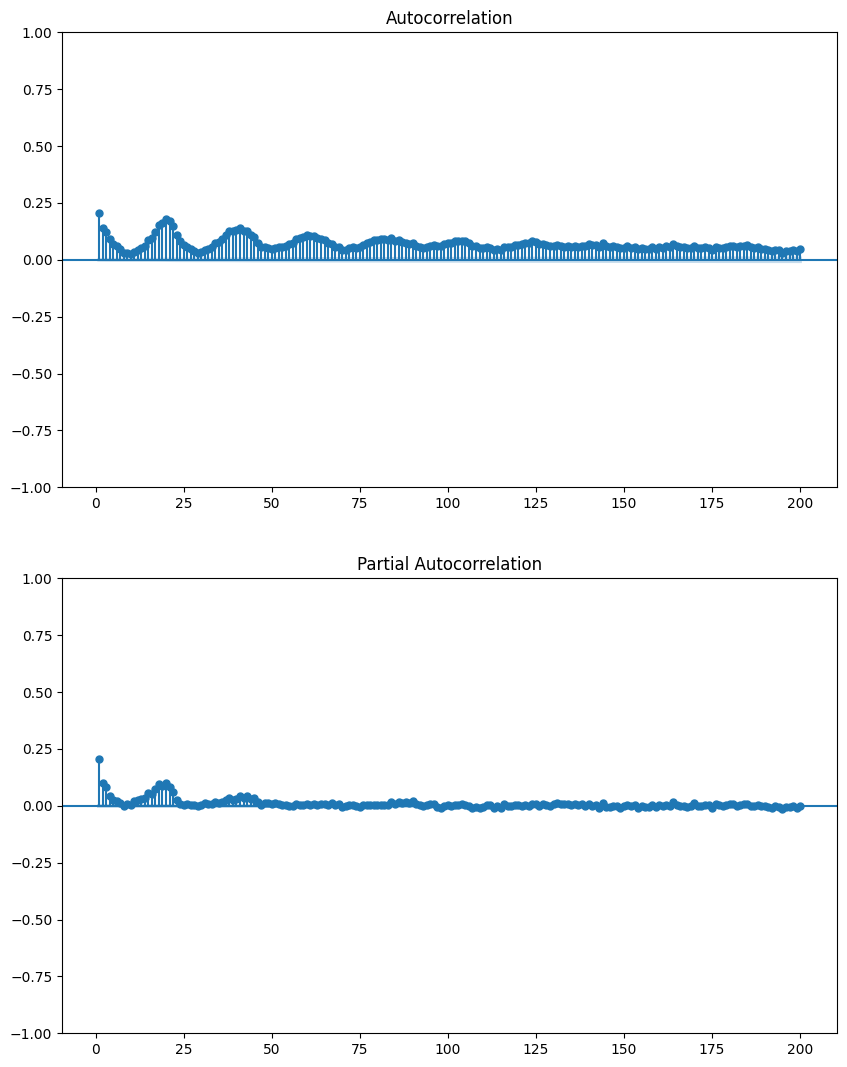

In [132]:
import matplotlib.pyplot as plt

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(regular_data_batched['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

import qdatoolkit as qda

_ = qda.Assumptions(regular_data_batched['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(regular_data_batched['temp_std']).independence()  # Controllo di indipendenza

In [133]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare features and target
X = regular_data_batched[['layer_id', 'x', 'y']].values
y = regular_data_batched['temp_std'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.46166480992229747


/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/qdatoolkit/models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


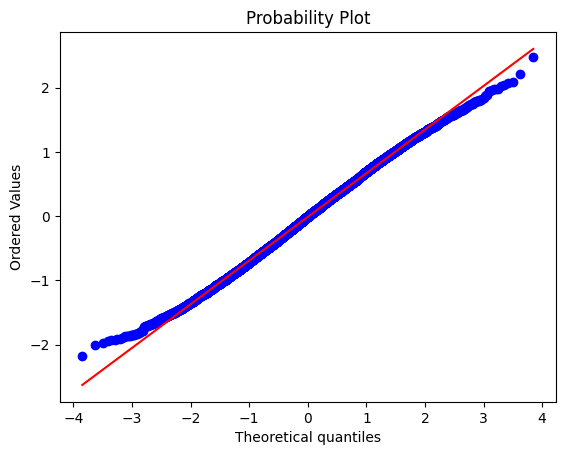

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.998
Shapiro-wilk test p-value = 0.000
Runs test statistic = -2.287
Runs test p-value = 0.022



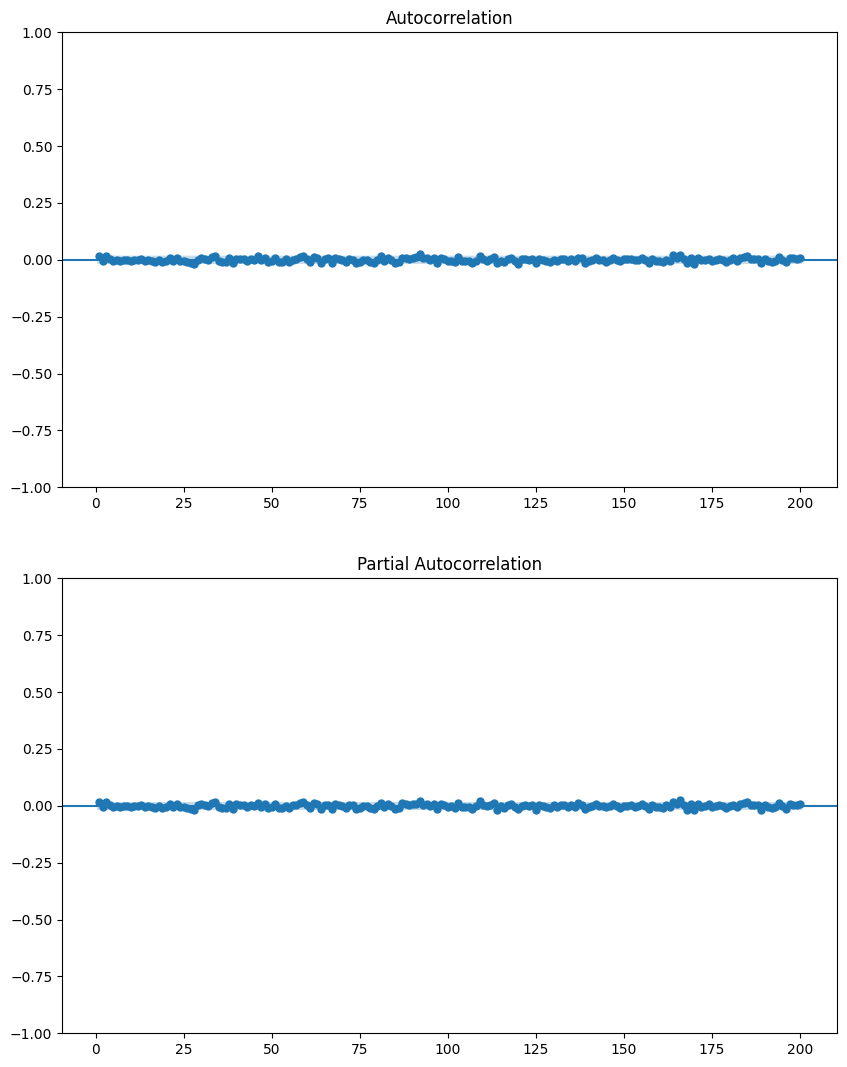

In [134]:
residuals = y_test - y_pred
_=qda.Assumptions(residuals).normality()  # Controllo di normalità
_=qda.Assumptions(residuals).independence()  # Controllo di indipendenza

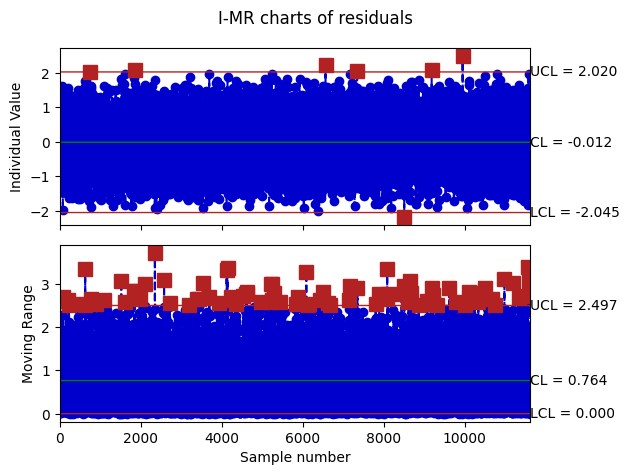

In [135]:
# Create a DataFrame for the residuals
df_SCC = pd.DataFrame(residuals, columns=['residuals'])

# Plot the I-MR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'residuals')

In [136]:
# Conta i punti fuori controllo nella carta I (Individual)
out_of_control_I = ((df_SCC_IMR['residuals'] > df_SCC_IMR['I_UCL']) | (df_SCC_IMR['residuals'] < df_SCC_IMR['I_LCL'])).sum()

# Conta i punti fuori controllo nella carta MR (Moving Range)
out_of_control_MR = ((df_SCC_IMR['MR'] > df_SCC_IMR['MR_UCL']) | (df_SCC_IMR['MR'] < df_SCC_IMR['MR_LCL'])).sum()

print(f"Punti fuori controllo nella carta I: {out_of_control_I}")
print(f"Punti fuori controllo nella carta MR: {out_of_control_MR}")

Punti fuori controllo nella carta I: 7
Punti fuori controllo nella carta MR: 87


In [137]:
len(residuals)
print(len(residuals))

11611
